In [25]:
from vqf.preprocessing import create_clauses
from itertools import product
import pandas as pd
from IPython.display import display
from sympy import simplify
import numpy as np
import sys

sys.path.append(f"./../")
from src.clause_utils import table_form
from src import Clause, SetsGraph

In [26]:
# p = 5
# q = 3

# p = 7
# q = 3

# p = 11
# q = 7

p = 241
q = 233

# p = 13
# q = 11

# p = 557
# q = 523

m = p * q

p_bits, q_bits, z_bits, clauses = create_clauses(
    m, apply_preprocessing=False, verbose=False
)

for c in clauses:
    display(c)

p_0*q_0 - 1

p_0*q_1 + p_1*q_0 - 512*z_1_10 - 1024*z_1_11 - 2048*z_1_12 - 4096*z_1_13 - 8192*z_1_14 - 16384*z_1_15 - 2*z_1_2 - 4*z_1_3 - 8*z_1_4 - 16*z_1_5 - 32*z_1_6 - 64*z_1_7 - 128*z_1_8 - 256*z_1_9

p_0*q_2 + p_1*q_1 + p_2*q_0 + z_1_2 - 256*z_2_10 - 512*z_2_11 - 1024*z_2_12 - 2048*z_2_13 - 4096*z_2_14 - 8192*z_2_15 - 2*z_2_3 - 4*z_2_4 - 8*z_2_5 - 16*z_2_6 - 32*z_2_7 - 64*z_2_8 - 128*z_2_9

p_0*q_3 + p_1*q_2 + p_2*q_1 + p_3*q_0 + z_1_3 + z_2_3 - 128*z_3_10 - 256*z_3_11 - 512*z_3_12 - 1024*z_3_13 - 2048*z_3_14 - 4096*z_3_15 - 2*z_3_4 - 4*z_3_5 - 8*z_3_6 - 16*z_3_7 - 32*z_3_8 - 64*z_3_9 - 1

p_0*q_4 + p_1*q_3 + p_2*q_2 + p_3*q_1 + p_4*q_0 + z_1_4 + z_2_4 + z_3_4 - 64*z_4_10 - 128*z_4_11 - 256*z_4_12 - 512*z_4_13 - 1024*z_4_14 - 2048*z_4_15 - 2*z_4_5 - 4*z_4_6 - 8*z_4_7 - 16*z_4_8 - 32*z_4_9 - 1

p_0*q_5 + p_1*q_4 + p_2*q_3 + p_3*q_2 + p_4*q_1 + p_5*q_0 + z_1_5 + z_2_5 + z_3_5 + z_4_5 - 32*z_5_10 - 64*z_5_11 - 128*z_5_12 - 256*z_5_13 - 512*z_5_14 - 1024*z_5_15 - 2*z_5_6 - 4*z_5_7 - 8*z_5_8 - 16*z_5_9

p_0*q_6 + p_1*q_5 + p_2*q_4 + p_3*q_3 + p_4*q_2 + p_5*q_1 + p_6*q_0 + z_1_6 + z_2_6 + z_3_6 + z_4_6 + z_5_6 - 16*z_6_10 - 32*z_6_11 - 64*z_6_12 - 128*z_6_13 - 256*z_6_14 - 512*z_6_15 - 2*z_6_7 - 4*z_6_8 - 8*z_6_9 - 1

p_0*q_7 + p_1*q_6 + p_2*q_5 + p_3*q_4 + p_4*q_3 + p_5*q_2 + p_6*q_1 + p_7*q_0 + z_1_7 + z_2_7 + z_3_7 + z_4_7 + z_5_7 + z_6_7 - 8*z_7_10 - 16*z_7_11 - 32*z_7_12 - 64*z_7_13 - 128*z_7_14 - 256*z_7_15 - 2*z_7_8 - 4*z_7_9

p_1*q_7 + p_2*q_6 + p_3*q_5 + p_4*q_4 + p_5*q_3 + p_6*q_2 + p_7*q_1 + p_8*q_0 + z_1_8 + z_2_8 + z_3_8 + z_4_8 + z_5_8 + z_6_8 + z_7_8 - 4*z_8_10 - 8*z_8_11 - 16*z_8_12 - 32*z_8_13 - 64*z_8_14 - 128*z_8_15 - 2*z_8_9 - 1

p_2*q_7 + p_3*q_6 + p_4*q_5 + p_5*q_4 + p_6*q_3 + p_7*q_2 + p_8*q_1 + p_9*q_0 + z_1_9 + z_2_9 + z_3_9 + z_4_9 + z_5_9 + z_6_9 + z_7_9 + z_8_9 - 2*z_9_10 - 4*z_9_11 - 8*z_9_12 - 16*z_9_13 - 32*z_9_14 - 64*z_9_15 - 1

p_10*q_0 + p_3*q_7 + p_4*q_6 + p_5*q_5 + p_6*q_4 + p_7*q_3 + p_8*q_2 + p_9*q_1 - 2*z_10_11 - 4*z_10_12 - 8*z_10_13 - 16*z_10_14 - 32*z_10_15 + z_1_10 + z_2_10 + z_3_10 + z_4_10 + z_5_10 + z_6_10 + z_7_10 + z_8_10 + z_9_10

p_10*q_1 + p_11*q_0 + p_4*q_7 + p_5*q_6 + p_6*q_5 + p_7*q_4 + p_8*q_3 + p_9*q_2 + z_10_11 - 2*z_11_12 - 4*z_11_13 - 8*z_11_14 - 16*z_11_15 + z_1_11 + z_2_11 + z_3_11 + z_4_11 + z_5_11 + z_6_11 + z_7_11 + z_8_11 + z_9_11 - 1

p_10*q_2 + p_11*q_1 + p_12*q_0 + p_5*q_7 + p_6*q_6 + p_7*q_5 + p_8*q_4 + p_9*q_3 + z_10_12 + z_11_12 - 2*z_12_13 - 4*z_12_14 - 8*z_12_15 + z_1_12 + z_2_12 + z_3_12 + z_4_12 + z_5_12 + z_6_12 + z_7_12 + z_8_12 + z_9_12 - 1

p_10*q_3 + p_11*q_2 + p_12*q_1 + p_13*q_0 + p_6*q_7 + p_7*q_6 + p_8*q_5 + p_9*q_4 + z_10_13 + z_11_13 + z_12_13 - 2*z_13_14 - 4*z_13_15 + z_1_13 + z_2_13 + z_3_13 + z_4_13 + z_5_13 + z_6_13 + z_7_13 + z_8_13 + z_9_13

p_10*q_4 + p_11*q_3 + p_12*q_2 + p_13*q_1 + p_14*q_0 + p_7*q_7 + p_8*q_6 + p_9*q_5 + z_10_14 + z_11_14 + z_12_14 + z_13_14 - 2*z_14_15 + z_1_14 + z_2_14 + z_3_14 + z_4_14 + z_5_14 + z_6_14 + z_7_14 + z_8_14 + z_9_14 - 1

p_10*q_5 + p_11*q_4 + p_12*q_3 + p_13*q_2 + p_14*q_1 + p_15*q_0 + p_8*q_7 + p_9*q_6 + z_10_15 + z_11_15 + z_12_15 + z_13_15 + z_14_15 + z_1_15 + z_2_15 + z_3_15 + z_4_15 + z_5_15 + z_6_15 + z_7_15 + z_8_15 + z_9_15 - 1

p_10*q_6 + p_11*q_5 + p_12*q_4 + p_13*q_3 + p_14*q_2 + p_15*q_1 + p_9*q_7

p_10*q_7 + p_11*q_6 + p_12*q_5 + p_13*q_4 + p_14*q_3 + p_15*q_2

p_11*q_7 + p_12*q_6 + p_13*q_5 + p_14*q_4 + p_15*q_3

p_12*q_7 + p_13*q_6 + p_14*q_5 + p_15*q_4

p_13*q_7 + p_14*q_6 + p_15*q_5

p_14*q_7 + p_15*q_6

p_15*q_7

In [27]:
p_bits_simple, q_bits_simple, z_bits_simple, simplified_clauses = create_clauses(
    m, apply_preprocessing=True, verbose=False
)

for c in simplified_clauses:
    display(c)

0

0

q_1 + q_2 - z_2_3 - 2*z_2_4

p_3 + 2*q_1*q_2 + q_3 + z_2_3 - 2*z_3_4 - 4*z_3_5 - 1

p_3*q_1 + p_4 + q_1*q_3 + q_2 + q_4 + z_2_4 + z_3_4 - 2*z_4_5 - 4*z_4_6 - 1

p_3*q_2 + p_4*q_1 + p_5 + q_1*q_4 + q_2*q_3 + q_5 + z_3_5 + z_4_5 - 2*z_5_6 - 4*z_5_7 - 8*z_5_8

p_3*q_3 + p_4*q_2 + p_5*q_1 + p_6 + q_1*q_5 + q_2*q_4 + q_6 + z_4_6 + z_5_6 - 2*z_6_7 - 4*z_6_8 - 8*z_6_9 - 1

p_3*q_4 + p_4*q_3 + p_5*q_2 + p_6*q_1 + p_7 + q_1*q_6 + q_2*q_5 + q_7 + z_5_7 + z_6_7 - 8*z_7_10 - 2*z_7_8 - 4*z_7_9

p_3*q_5 + p_4*q_4 + p_5*q_3 + p_6*q_2 + p_7*q_1 + p_8 + q_1*q_7 + q_2*q_6 + z_5_8 + z_6_8 + z_7_8 - 4*z_8_10 - 8*z_8_11 - 2*z_8_9 - 1

p_3*q_6 + p_4*q_5 + p_5*q_4 + p_6*q_3 + p_7*q_2 + p_8*q_1 + p_9 + q_2*q_7 + z_6_9 + z_7_9 + z_8_9 - 2*z_9_10 - 4*z_9_11 - 8*z_9_12 - 1

p_10 + p_3*q_7 + p_4*q_6 + p_5*q_5 + p_6*q_4 + p_7*q_3 + p_8*q_2 + p_9*q_1 - 2*z_10_11 - 4*z_10_12 - 8*z_10_13 + z_7_10 + z_8_10 + z_9_10

p_10*q_1 + p_11 + p_4*q_7 + p_5*q_6 + p_6*q_5 + p_7*q_4 + p_8*q_3 + p_9*q_2 + z_10_11 - 2*z_11_12 - 4*z_11_13 - 8*z_11_14 + z_8_11 + z_9_11 - 1

p_10*q_2 + p_11*q_1 + p_12 + p_5*q_7 + p_6*q_6 + p_7*q_5 + p_8*q_4 + p_9*q_3 + z_10_12 + z_11_12 - 2*z_12_13 - 4*z_12_14 - 8*z_12_15 + z_9_12 - 1

p_10*q_3 + p_11*q_2 + p_12*q_1 + p_13 + p_6*q_7 + p_7*q_6 + p_8*q_5 + p_9*q_4 + z_10_13 + z_11_13 + z_12_13 - 2*z_13_14 - 4*z_13_15

p_10*q_4 + p_11*q_3 + p_12*q_2 + p_13*q_1 + p_14 + p_7*q_7 + p_8*q_6 + p_9*q_5 + z_11_14 + z_12_14 + z_13_14 - 2*z_14_15 - 1

p_10*q_5 + p_11*q_4 + p_12*q_3 + p_13*q_2 + p_14*q_1 + p_15 + p_8*q_7 + p_9*q_6 + z_12_15 + z_13_15 + z_14_15 - 1

p_10*q_6 + p_11*q_5 + p_12*q_4 + p_13*q_3 + p_14*q_2 + p_15*q_1 + p_9*q_7

p_10*q_7 + p_11*q_6 + p_12*q_5 + p_13*q_4 + p_14*q_3 + p_15*q_2

p_11*q_7 + p_12*q_6 + p_13*q_5 + p_14*q_4 + p_15*q_3

p_12*q_7 + p_13*q_6 + p_14*q_5 + p_15*q_4

p_13*q_7 + p_14*q_6 + p_15*q_5

p_14*q_7 + p_15*q_6

p_15*q_7

In [28]:
def get_space_eff_clauses(simplified_clauses):
    eff_clauses = {}
    for c in simplified_clauses:
        if c != 0:
            c = Clause(c)
            table = c.reduce_space().remove_carry_bits()
            bits = table.bits
            eff_clauses[table] = bits
    return eff_clauses


eff_clauses = get_space_eff_clauses(simplified_clauses)

for bits in eff_clauses.values():
    print(bits)

{q_1, q_2}
{p_3, q_1, q_2, q_3}
{p_3, q_1, q_4, q_2, p_4, q_3}
{p_3, q_1, q_5, q_4, q_2, p_4, p_5, q_3}
{p_3, q_6, q_5, q_1, q_4, q_2, p_4, p_5, p_6, q_3}
{p_3, q_1, q_4, p_7, q_6, q_2, q_5, p_4, p_5, p_6, q_7, q_3}
{p_3, q_1, q_5, q_4, p_7, q_2, q_6, p_4, p_5, p_6, p_8, q_7, q_3}
{p_3, q_6, q_5, q_4, p_7, q_2, q_1, p_4, p_5, p_6, p_9, p_8, q_7, q_3}
{p_3, q_6, q_5, q_4, p_10, p_7, q_2, q_1, p_4, p_5, p_6, p_9, p_8, q_7, q_3}
{q_1, q_5, q_4, p_10, q_2, p_7, q_6, p_4, p_5, p_6, p_9, p_8, q_7, p_11, q_3}
{q_1, q_4, q_5, p_7, p_10, q_2, q_6, p_12, p_5, p_6, p_9, p_8, q_7, p_11, q_3}
{q_1, q_4, q_5, p_7, p_10, q_2, q_6, p_12, p_6, p_13, p_9, p_8, q_7, p_11, q_3}
{q_1, q_5, q_4, p_7, p_10, q_2, q_6, p_12, p_13, p_14, p_9, p_8, q_7, p_11, q_3}
{q_1, q_5, q_4, p_10, q_2, p_12, q_6, p_15, p_13, p_14, p_9, p_8, q_7, p_11, q_3}
{q_6, q_5, q_4, p_10, q_2, p_12, q_1, p_15, p_13, p_14, p_9, q_7, p_11, q_3}
{q_6, q_5, q_4, p_10, q_2, p_12, p_15, p_13, p_14, q_7, p_11, q_3}
{q_6, q_5, q_4, p_12, p_15

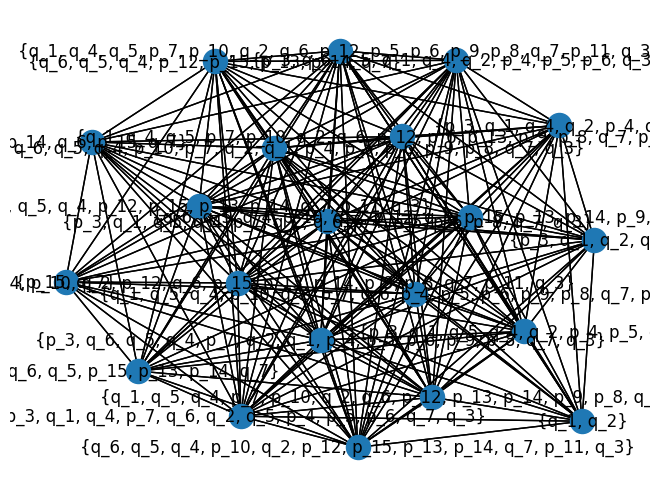

In [29]:
pq_bits = eff_clauses.values()
graph = SetsGraph(pq_bits)
disjoint_sets = graph.disjoint_sets
graph.draw()

In [37]:
def get_best_bits_table(eff_clauses):
    min_r = float("inf")  # Initialize min_r to infinity
    best_table = None  # Initialize best_table to None
    tables = eff_clauses.keys()

    for t in tables:
        r = t.calc_r()
        if r < min_r:
            min_r = r
            best_table = t.table

    return best_table


# Usage
best_clause = get_best_bits_table(eff_clauses)
display(best_clause)

,q_6,q_5,q_4,p_10,q_2,p_12,q_1,p_15,p_13,p_14,p_9,q_7,p_11,q_3
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,0,0,1,1
4,0,0,0,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2182,1,1,1,0,1,0,1,0,0,0,1,0,0,0
2183,1,1,1,0,1,0,1,0,0,0,1,0,0,1
2184,1,1,1,0,1,0,1,0,1,0,0,0,0,0
2185,1,1,1,0,1,0,1,0,1,0,0,1,0,0


In [31]:
def get_key_by_value(dictionary, value):
    for key, val in dictionary.items():
        if val == value:
            return key
    return None  # Value not found

In [32]:
def get_superposition_tables(simplified_clauses, disjoint_sets):
    superposition_tables = []
    if len(disjoint_sets) == 0:
        best_clause = get_best_bits_table(simplified_clauses)
        superposition_tables.append(best_clause)

    elif len(disjoint_sets) == 1:
        for s in disjoint_sets[0]:
            table = get_key_by_value(eff_clauses, s).table
            superposition_tables.append(table)

    else:
        raise NotImplementedError

    return superposition_tables


superposition_tables = get_superposition_tables(simplified_clauses, disjoint_sets)

for table in superposition_tables:
    display(table)

NotImplementedError: 

In [35]:
for s in disjoint_sets:
    print(f"Disjoint set: {s}")

Disjoint set: [{q_1, q_2}, {q_6, q_5, q_4, p_12, p_15, p_13, p_14, q_7, p_11, q_3}]
Disjoint set: [{q_1, q_2}, {q_6, q_5, q_4, p_12, p_15, p_13, p_14, q_7}]
Disjoint set: [{q_1, q_2}, {q_6, q_5, p_15, p_13, p_14, q_7}]
Disjoint set: [{q_1, q_2}, {p_14, q_6, p_15, q_7}]
Disjoint set: [{q_1, q_2}, {p_15, q_7}]
Disjoint set: [{p_3, q_1, q_2, q_3}, {q_6, q_5, q_4, p_12, p_15, p_13, p_14, q_7}]
Disjoint set: [{p_3, q_1, q_2, q_3}, {q_6, q_5, p_15, p_13, p_14, q_7}]
Disjoint set: [{p_3, q_1, q_2, q_3}, {p_14, q_6, p_15, q_7}]
Disjoint set: [{p_3, q_1, q_2, q_3}, {p_15, q_7}]
Disjoint set: [{p_3, q_1, q_4, q_2, p_4, q_3}, {q_6, q_5, p_15, p_13, p_14, q_7}]
Disjoint set: [{p_3, q_1, q_4, q_2, p_4, q_3}, {p_14, q_6, p_15, q_7}]
Disjoint set: [{p_3, q_1, q_4, q_2, p_4, q_3}, {p_15, q_7}]
Disjoint set: [{p_3, q_1, q_5, q_4, q_2, p_4, p_5, q_3}, {p_14, q_6, p_15, q_7}]
Disjoint set: [{p_3, q_1, q_5, q_4, q_2, p_4, p_5, q_3}, {p_15, q_7}]
Disjoint set: [{p_3, q_6, q_5, q_1, q_4, q_2, p_4, p_5, p_6,